In [137]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000254.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000322.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000812.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000737.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_002383.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_001654.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_001290.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000646.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_002199.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_003448.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_003776.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000311.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_003489.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000468.jpg
/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000626.jpg
/kaggle/input/animal-faces/afhq/val/dog/pixabay_dog_000971.j

***Import Required Libraries***

In [138]:
import torch 
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

device='cuda' if torch.cuda.is_available() else 'cpu'
print('Device Available : ',device)

Device Available :  cuda


In [139]:
# /kaggle/input/animal-faces/afhq/train
# /kaggle/input/animal-faces/afhq/val 
image_path=[]
labels=[]

for i in os.listdir('/kaggle/input/animal-faces/afhq'):
    # print(i)
    for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
        # print(label)
        for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
            # print(image)
            image_path.append(f"/kaggle/input/animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)

***Create Dataframe of Image links and their Labels***

In [140]:

data_df=pd.DataFrame(zip(image_path,labels),columns=['image_path','labels'])

print(data_df.shape)
print(data_df['labels'].unique())
print(data_df['labels'].value_counts())
data_df.head()

(16130, 2)
['dog' 'wild' 'cat']
labels
cat     5653
dog     5239
wild    5238
Name: count, dtype: int64


,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


***Divide into Train Test Validation Dataset***

In [141]:
train=data_df.sample(frac=0.7)
test=data_df.drop(train.index)
val=test.sample(frac=0.5)
test=test.drop(val.index)

print(train.shape,test.shape,val.shape)


(11291, 2) (2419, 2) (2420, 2)


***Label Encoder for target Column***

In [142]:
label_encoder=LabelEncoder()

label_encoder.fit(data_df['labels']) 

transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

***Define CustomDataset***

In [143]:
class CustomDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe=dataframe
        self.transform=transform
        # transform the lables then store in labels
        self.labels=torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    # Provide the length of the particular dataframe
    def __len__(self):
        return self.dataframe.shape[0]

    # Provide particular image acc to index 
    def __getitem__(self,index):
        img_path=self.dataframe.iloc[index,0]
        label=self.labels[index]
        image=Image.open(img_path).convert('RGB')

        # if transform available apply it 
        if self.transform:
            image=self.transform(image).to(device)
        
        return image,label

***Form Train Test Validation Dataset***

In [144]:
train_dataset=CustomDataset(dataframe=train,transform=transform)
test_dataset=CustomDataset(dataframe=test,transform=transform)
val_dataset=CustomDataset(dataframe=val,transform=transform)

In [145]:
train_dataset.__len__()

11291

In [146]:
test_dataset.__len__()

2419

***Plot Random Images***

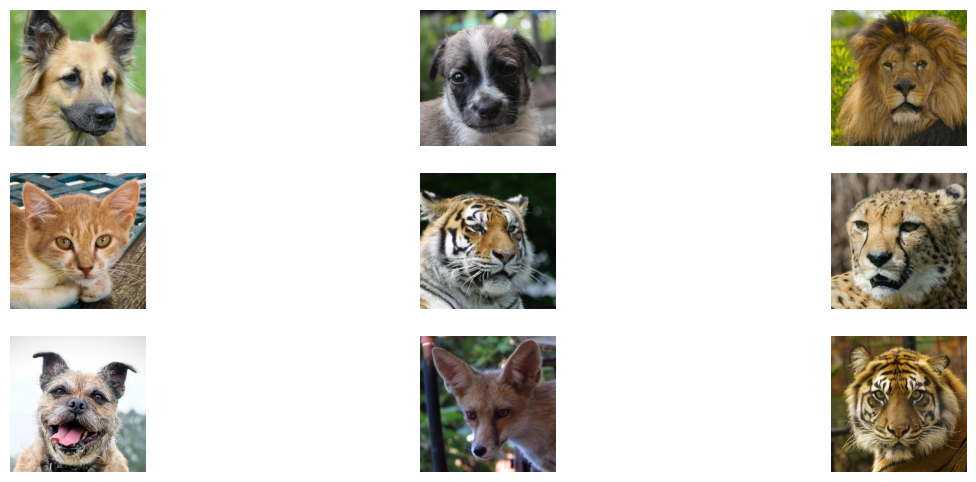

In [147]:
nrows=3
ncols=3
f,axs=plt.subplots(nrows,ncols,figsize=(15,6))

for row in range(nrows):
    for col in range(ncols):
        image=Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
        axs[row,col].imshow(image)
        axs[row,col].axis('off')
plt.show()

In [148]:
LR=1e-4
BATCH_SIZE=16
EPOCHS=10

***Data Loader***

In [149]:
train_dataset_loader=DataLoader(train_dataset,BATCH_SIZE,shuffle=True)
test_dataset_loader=DataLoader(test_dataset,BATCH_SIZE,shuffle=True)
val_dataset_loader=DataLoader(val_dataset,BATCH_SIZE,shuffle=True)

***Define Model***

In [150]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1) # Donto effect image size
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.pooling=nn.MaxPool2d(2,2) # Reduce size of image 
        self.relu=nn.ReLU() # Activation function
        self.flatten=nn.Flatten() #Flatten the image to 1d array
        self.linear=nn.Linear((128*16*16),128)
        self.output=nn.Linear(128,len(data_df['labels'].unique()))

    
    def forward(self,x):
        x=self.conv1(x) # ->(32,128,128)
        x=self.pooling(x) # ->(32,64,64)
        x=self.relu(x)
        
        x=self.conv2(x) # ->(64,64,64)
        x=self.pooling(x) # ->(64,32,32)
        x=self.relu(x)

        x=self.conv3(x) # ->(128,32,32)
        x=self.pooling(x) # ->(128,16,16)
        x=self.relu(x)

        x=self.flatten(x)
        x=self.linear(x)
        x=self.output(x)
        return x
        

In [151]:
model=Model().to(device)

***Model Summary***

In [152]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

***Define Loss and Optimizer***

In [153]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=LR)

***Start Training***

In [154]:
total_loss_train_plot = []
total_loss_val_plot = []

total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_dataset_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward() 
        
        train_Acc = (torch.argmax(outputs, dim=1) == labels).sum().item()
        total_acc_train += train_Acc
        optimizer.step()

    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataset_loader:
            outputs = model(inputs)

            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_Acc = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_acc_val += val_Acc

    total_loss_train_plot.append(round(total_loss_train / len(train_dataset_loader), 4))
    total_loss_val_plot.append(round(total_loss_val / len(val_dataset_loader), 4))

    total_acc_train_plot.append(round((total_acc_train / len(train_dataset)) * 100, 2))
    total_acc_val_plot.append(round((total_acc_val / len(val_dataset)) * 100, 2))

    print(f"EPOCH {epoch + 1} Train Loss: {round(total_loss_train / len(train_dataset_loader), 4)} | Train Acc: {round((total_acc_train / len(train_dataset)) * 100, 2)}%")
    print(f"EPOCH {epoch + 1} Val Loss:   {round(total_loss_val / len(val_dataset_loader), 4)} | Val Acc: {round((total_acc_val / len(val_dataset)) * 100, 2)}%")


EPOCH 1 Train Loss: 0.4649 | Train Acc: 80.62%
EPOCH 1 Val Loss:   0.2691     | Val Acc: 89.67%
EPOCH 2 Train Loss: 0.1992 | Train Acc: 92.82%
EPOCH 2 Val Loss:   0.1794     | Val Acc: 93.84%
EPOCH 3 Train Loss: 0.1336 | Train Acc: 95.08%
EPOCH 3 Val Loss:   0.1514     | Val Acc: 94.75%
EPOCH 4 Train Loss: 0.0915 | Train Acc: 96.77%
EPOCH 4 Val Loss:   0.1546     | Val Acc: 95.0%
EPOCH 5 Train Loss: 0.0661 | Train Acc: 97.47%
EPOCH 5 Val Loss:   0.1546     | Val Acc: 94.88%
EPOCH 6 Train Loss: 0.0514 | Train Acc: 98.1%
EPOCH 6 Val Loss:   0.1623     | Val Acc: 95.17%
EPOCH 7 Train Loss: 0.034 | Train Acc: 98.77%
EPOCH 7 Val Loss:   0.1641     | Val Acc: 95.08%
EPOCH 8 Train Loss: 0.0251 | Train Acc: 99.14%
EPOCH 8 Val Loss:   0.1865     | Val Acc: 94.88%
EPOCH 9 Train Loss: 0.0202 | Train Acc: 99.41%
EPOCH 9 Val Loss:   0.1849     | Val Acc: 95.37%
EPOCH 10 Train Loss: 0.0141 | Train Acc: 99.57%
EPOCH 10 Val Loss:   0.2116     | Val Acc: 95.33%


***Test dataset Accuracy***

In [155]:
with torch.no_grad():
    total_loss_test=0
    total_acc_test=0
    for inputs,labels in test_dataset_loader:
        predict=model(inputs)
        acc=(torch.argmax(predict,dim=1)==labels).sum().item()
        test_loss=criterion(predict,labels)
        
        total_loss_test+=test_loss.item()
        total_acc_test+=acc

print(f"Accuracy score is: {round((total_acc_test / len(test_dataset)) * 100, 4)}%")


Accuracy score is: 95.7007%


***Loss Accuracy Graph for Training and Validation***

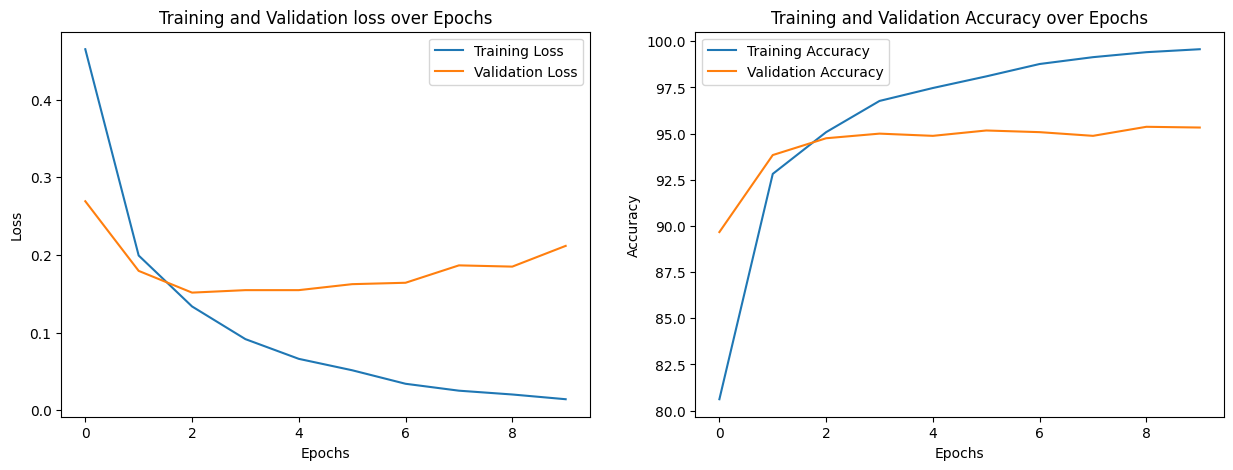

In [156]:
fig ,axs=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label='Training Loss')
axs[0].plot(total_loss_val_plot,label='Validation Loss')
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()


axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_val_plot,label='Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.show()

***Testing***

In [157]:
image_path="/kaggle/input/animal-faces/afhq/train/dog/flickr_dog_000004.jpg"

def predict_image(image_path):
    image=Image.open(image_path).convert('RGB')
    image=transform(image).to(device)
    image=image.unsqueeze(0)
    pred=model(image)
    output=torch.argmax(pred,axis=1).item()
    return label_encoder.inverse_transform([output]).item()


predict_image(image_path)

'dog'